In [4]:
# Google drive data links
protein_id = "1j-uTZm77Xfw91AMTFxfRVY0Cq1er98kB"
kcal_id = "1wisWTD_nKcu2jvPDZG4-1XVzb3UPg2CF"
fat_id = "1X8gK6CoGRqM8KIi9aKYMWbVgGsL60ZmW"
quantity_id = "1KBqJe3AzOlGoina3aWiNaUGT5f02EILZ"

url_protein = f"https://drive.google.com/uc?id={protein_id}"
url_kcal = f"https://drive.google.com/uc?id={kcal_id}"
url_fat = f"https://drive.google.com/uc?id={fat_id}"
url_quantity = f"https://drive.google.com/uc?id={quantity_id}"

In [5]:
import pandas as pd

### Data calculations

All data is calculated as a percentage of total intake amount

In [6]:
# Dataframes
protein = pd.read_csv(url_protein)
kcal    = pd.read_csv(url_kcal)
fat = pd.read_csv(url_fat)
quantity = pd.read_csv(url_quantity)

In [7]:
from sklearn.impute import KNNImputer

In [8]:
#impute missing data
def impute_missing(df):
    #transform data from object variable to numerical variable
    df['Undernourished'] = df['Undernourished'].map(lambda x: '2.4' if x == '<2.5' else x).astype('float64')

    col = list(df.columns)
    col.remove('Unit (all except Population)') #remove '%' unit
    col.remove('Country') #object variable
    # nan_col = [c for c in col if df[c].isnull().sum() > 0]
    # not_nan_col = [c for c in col if c not in nan_col]


    imputer = KNNImputer(n_neighbors=3)
    imp_data = imputer.fit_transform(df[col])
    new = pd.DataFrame(imp_data, columns = col)

    return pd.concat([df[['Country']], new], axis=1) #concat 'Country' to data frame then return

In [9]:
# Impute missing data
fat = impute_missing(fat)
quantity = impute_missing(quantity)
kcal = impute_missing(kcal)
protein = impute_missing(protein)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_19008/814306840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='Confirmed', ascending=False, inplace=True)


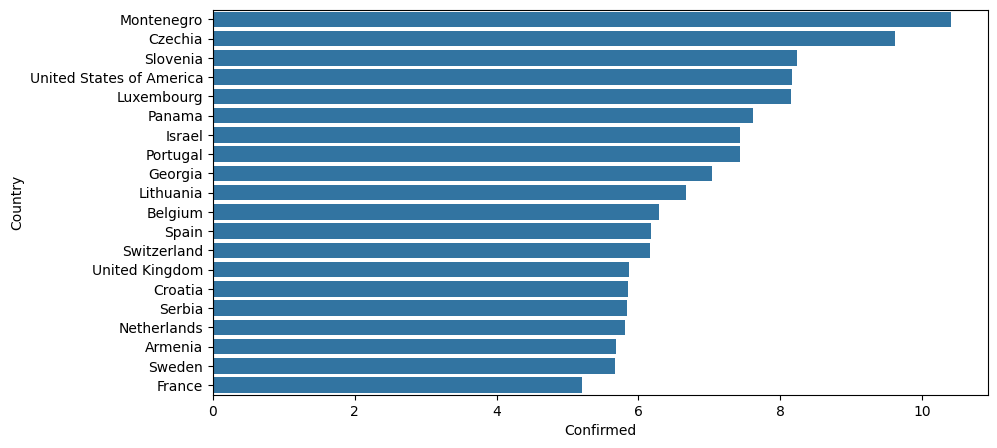

In [11]:
# Chart of number of confirmed cases by country. Based on kcal data.
fig, ax = plt.subplots(figsize=(10, 5))

df = kcal[['Country', 'Confirmed', 'Deaths', 'Recovered', 'Active']]
df.sort_values(by='Confirmed', ascending=False, inplace=True)
sns.barplot(x="Confirmed", y="Country", data=df[:20]);

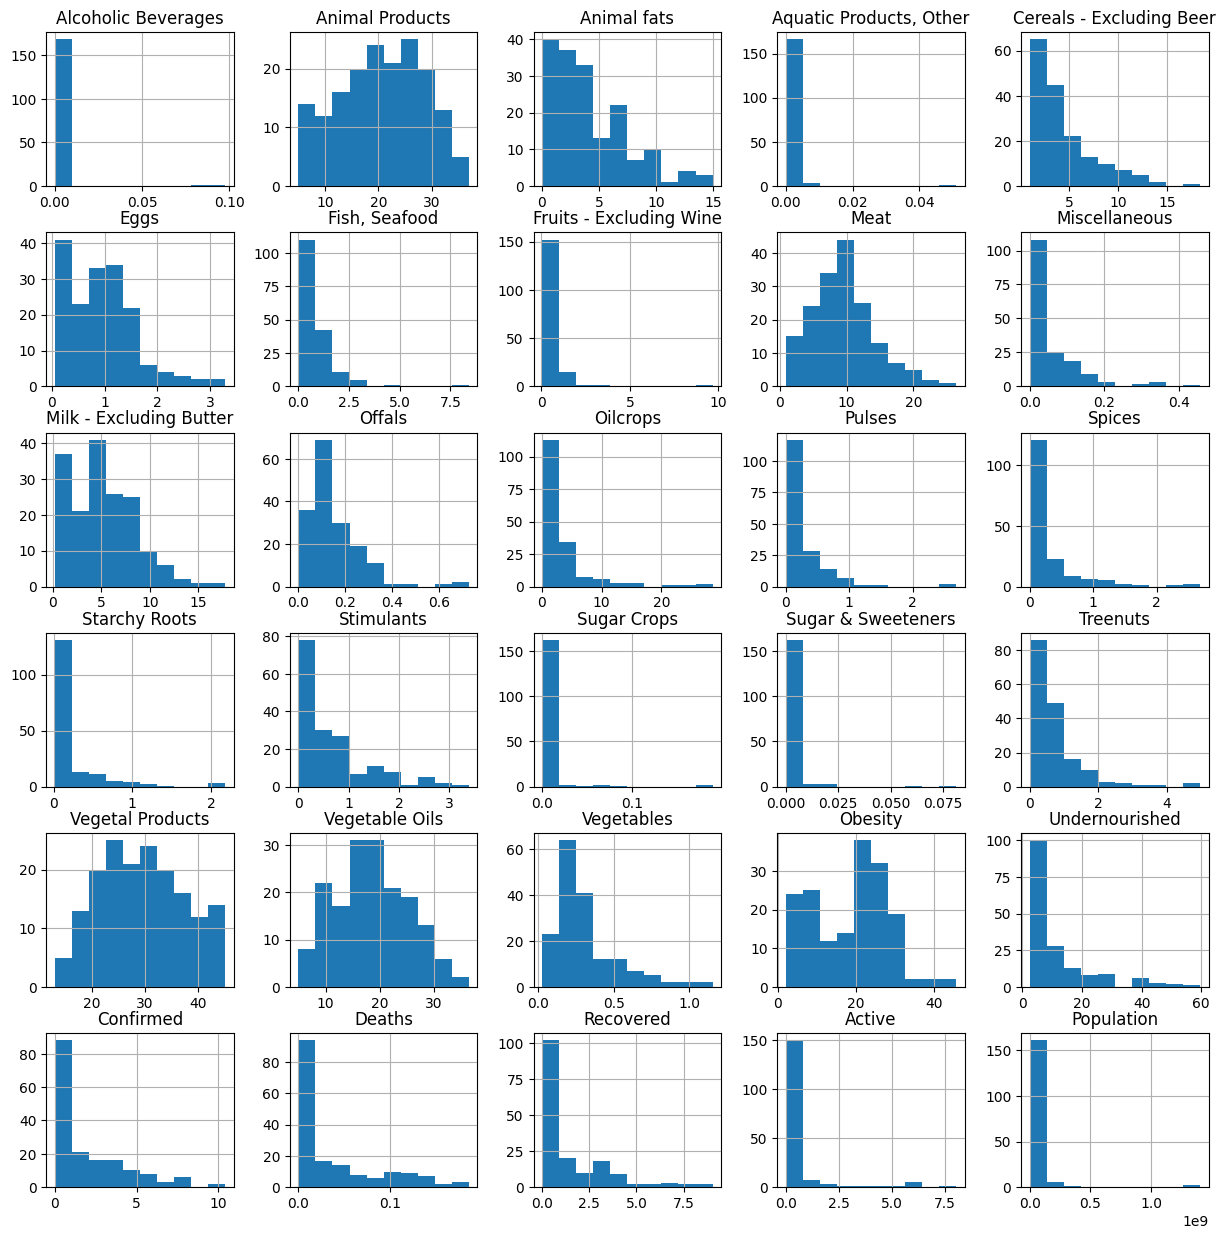

In [12]:
# Distribution of fat features
fat.hist(figsize=(15, 15));

In [13]:
fat = fat.drop("Country", axis=1)

In [14]:
# Linear corellation among data
corr = fat.corr()
corr.sort_values(["Confirmed"],ascending = False, inplace = True)

In [15]:
print(corr.Confirmed)

Confirmed                   1.000000
Deaths                      0.862763
Recovered                   0.822537
Active                      0.558832
Animal fats                 0.513481
Obesity                     0.491655
Animal Products             0.475264
Stimulants                  0.460834
Milk - Excluding Butter     0.421414
Eggs                        0.337419
Treenuts                    0.245443
Meat                        0.142430
Vegetables                 -0.013800
Population                 -0.071473
Sugar & Sweeteners         -0.075241
Alcoholic Beverages        -0.081207
Miscellaneous              -0.082130
Aquatic Products, Other    -0.086361
Fruits - Excluding Wine    -0.087742
Sugar Crops                -0.114373
Vegetable Oils             -0.143429
Fish, Seafood              -0.156109
Spices                     -0.169547
Offals                     -0.228645
Pulses                     -0.303460
Starchy Roots              -0.307728
Oilcrops                   -0.353353
C

# Linear Regression

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [17]:
X = fat.loc[:, ~fat.columns.isin(["Confirmed", "Deaths", "Recovered", "Population"])]
y = fat["Confirmed"]

In [18]:
# Random state 21 works well for Linear Regression
# Random state 23 works well for GBM
X_values = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.1, random_state=23)

In [19]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)
r2 = r2_score(y_test, y_pred)
print(r2)

1.7275195944895492
0.48867764305399797


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
# Instantiate the GBM model
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.10, max_depth=3, random_state=42)

In [22]:
# Fit the model to the training data
gbm.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [23]:
y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
print(gbm.score(X_test, y_test))

0.9326666501717926
0.7239433281498108


In [24]:
import xgboost as xgb

In [25]:
# instantiate the classifier
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.10, max_depth=3)

# fit the classifier to the training data
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.6189957244237005

# KFold with a GridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR


In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

In [29]:
# Instantiate the SVR regressor
svr = SVR()

In [30]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='neg_mean_squared_error')

In [32]:
# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
# Evaluate the best estimator

In [33]:
# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator: SVR(C=10, gamma=0.01)


In [34]:
final_model = SVR(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
final_model.fit(X_train, y_train)

SVR(C=10, gamma=0.01)

In [35]:
final_model.score(X_test, y_test)

0.6568249259352423

In [ ]:
y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [41]:
# Create KFold object
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

# Iterate through the splits
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the model
    final_model.fit(X_train, y_train)

    # Evaluate the model
    accuracy = final_model.score(X_test, y_test)
    print("Accuracy:", accuracy)

Accuracy: 0.5270624723919567
Accuracy: 0.6953587506360231
Accuracy: 0.24460280822633218
Accuracy: 0.45889455396441714
Accuracy: 0.5415295597959777
Accuracy: 0.6093909853363938
Accuracy: 0.5899271770722643
